## DATA 608 Project 1 Infrastructure Investment & Jobs Act Funding Allocation
#### Author: Farhod Ibragimov

In this project I analyze the allocation of the Infrastructure Investment and Jobs Act funding by State and Territory.

The main goal to answer the following questions:

Is the allocation equitable based on the population of each of the States and Territories, or is bias apparent?

Does the allocation favor the political interests of the Biden administration?

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib.ticker import FuncFormatter 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
pio.renderers.default = "vscode"


from IPython.display import display



In [46]:
path = "https://raw.githubusercontent.com/farhodibr/CUNY-SPS-MSDS/refs/heads/main/DATA608/PROJECT1/iija_per_capita_analysis.csv"
iija_df = pd.read_csv(path)
display(iija_df.head())
iija_df.info()

,entity,total_billions,total_usd,population_2020,per_capita_usd,is_state_like,biden_win_2020
0,ALASKA,3.7000,3.700000e+09,733391.0,5045.057820,True,False
1,WYOMING,2.3000,2.300000e+09,576851.0,3987.164796,True,False
2,MONTANA,3.3000,3.300000e+09,1084225.0,3043.648689,True,False
3,NORTH DAKOTA,1.8000,1.800000e+09,779094.0,2310.375898,True,False
4,NORTHERN MARIANA ISLANDS,0.0833,8.330000e+07,47329.0,1760.020284,False,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   entity           57 non-null     object 
 1   total_billions   57 non-null     float64
 2   total_usd        57 non-null     float64
 3   population_2020  56 non-null     float64
 4   per_capita_usd   56 non-null     float64
 5   is_state_like    57 non-null     bool   
 6   biden_win_2020   51 non-null     object 
dtypes: bool(1), float64(4), object(2)
memory usage: 2.9+ KB


In [17]:
#checking for numeric data
num_cols = ["total_usd","population_2020","per_capita_usd"]
for col in num_cols:
    iija_df[col] = pd.to_numeric(iija_df[col], errors="coerce")

#checking for NaN values
nan_counts = iija_df[num_cols].isna().sum()
display(nan_counts)

total_usd          0
population_2020    1
per_capita_usd     1
dtype: int64

We will drop NAN rows

In [18]:
units = iija_df.dropna(subset=num_cols).copy()
units.shape

(56, 7)

## Population-proportional baseline

Idea: If funding was perfectly proportional to population, every unit gets:

### expected = national per-capita × population


In [19]:
national_total = float(units["total_usd"].sum())
national_pop   = float(units["population_2020"].sum())
national_pc    = national_total / national_pop
national_total, national_pop, national_pc

(193032400000.0, 335073176.0, 576.0902806496215)

In [20]:
units["expected_total_usd"]    = national_pc * units["population_2020"]
units["ratio_actual_expected"] = units["total_usd"] / units["expected_total_usd"]

#missing deviation columns
units["deviation_usd"] = units["total_usd"] - units["expected_total_usd"]
units["deviation_pct"] = 100.0 * units["deviation_usd"] / units["expected_total_usd"]


units["type"] = np.where(units["is_state_like"], "State/DC", "Territory")
units["above_baseline"] = np.where(units["ratio_actual_expected"] >= 1, "Above 1.0", "Below 1.0")

# formatting strings for tooltips
units["population_fmt"] = units["population_2020"].map(lambda x: f"{int(x):,}")
units["total_fmt"]      = units["total_usd"].map(lambda x: f"${x:,.0f}")
units["expected_fmt"]   = units["expected_total_usd"].map(lambda x: f"${x:,.0f}")
units["ratio_fmt"]      = units["ratio_actual_expected"].map(lambda x: f"{x:.2f}×")

display(
    units[["entity","population_2020","total_usd","expected_total_usd",
           "ratio_actual_expected","deviation_pct"]].head(8)
)

,entity,population_2020,total_usd,expected_total_usd,ratio_actual_expected,deviation_pct
0,ALASKA,733391.0,3.700000e+09,4.224994e+08,8.757408,775.740833
1,WYOMING,576851.0,2.300000e+09,3.323183e+08,6.921076,592.107631
2,MONTANA,1084225.0,3.300000e+09,6.246115e+08,5.283284,428.328422
3,NORTH DAKOTA,779094.0,1.800000e+09,4.488285e+08,4.010441,301.044068
4,NORTHERN MARIANA ISLANDS,47329.0,8.330000e+07,2.726578e+07,3.055112,205.511192
5,U.S. VIRGIN ISLANDS,87146.0,1.483000e+08,5.020396e+07,2.953950,195.395003
6,DISTRICT OF COLUMBIA,689545.0,1.100000e+09,3.972402e+08,2.769106,176.910563
7,SOUTH DAKOTA,886667.0,1.300000e+09,5.108002e+08,2.545026,154.502621


In [21]:
winners = (units.sort_values("ratio_actual_expected", ascending=False)
                [["entity","population_2020","total_usd","expected_total_usd",
                  "ratio_actual_expected","deviation_pct"]]
                .head(10))
losers  = (units.sort_values("ratio_actual_expected", ascending=True)
                [["entity","population_2020","total_usd","expected_total_usd",
                  "ratio_actual_expected","deviation_pct"]]
                .head(10))

display(winners)
display(losers)


,entity,population_2020,total_usd,expected_total_usd,ratio_actual_expected,deviation_pct
0,ALASKA,733391.0,3.700000e+09,4.224994e+08,8.757408,775.740833
1,WYOMING,576851.0,2.300000e+09,3.323183e+08,6.921076,592.107631
2,MONTANA,1084225.0,3.300000e+09,6.246115e+08,5.283284,428.328422
3,NORTH DAKOTA,779094.0,1.800000e+09,4.488285e+08,4.010441,301.044068
4,NORTHERN MARIANA ISLANDS,47329.0,8.330000e+07,2.726578e+07,3.055112,205.511192
5,U.S. VIRGIN ISLANDS,87146.0,1.483000e+08,5.020396e+07,2.953950,195.395003
6,DISTRICT OF COLUMBIA,689545.0,1.100000e+09,3.972402e+08,2.769106,176.910563
7,SOUTH DAKOTA,886667.0,1.300000e+09,5.108002e+08,2.545026,154.502621
8,AMERICAN SAMOA,49710.0,6.860000e+07,2.863745e+07,2.395465,139.546486
9,VERMONT,643077.0,8.521000e+08,3.704704e+08,2.300049,130.004874


,entity,population_2020,total_usd,expected_total_usd,ratio_actual_expected,deviation_pct
55,PUERTO RICO,3285874.0,9.937000e+08,1.892960e+09,0.524945,-47.505496
54,FLORIDA,21538187.0,8.200000e+09,1.240794e+10,0.660867,-33.913286
53,NORTH CAROLINA,10439388.0,4.500000e+09,6.014030e+09,0.748250,-25.174965
52,MARYLAND,6177224.0,2.700000e+09,3.558639e+09,0.758717,-24.128291
51,SOUTH CAROLINA,5118425.0,2.300000e+09,2.948675e+09,0.780011,-21.998861
50,CALIFORNIA,39538223.0,1.840000e+10,2.277759e+10,0.807812,-19.218832
49,GEORGIA,10711908.0,5.000000e+09,6.171026e+09,0.810238,-18.976197
48,MINNESOTA,5706494.0,2.700000e+09,3.287456e+09,0.821304,-17.869616
47,WISCONSIN,5893718.0,2.800000e+09,3.395314e+09,0.824666,-17.533392
46,TEXAS,29145505.0,1.420000e+10,1.679044e+10,0.845719,-15.428076


In [22]:

units["winner_label"] = np.select(
    [
        (units["is_state_like"] == True) & (units["biden_win_2020"] == True),
        (units["is_state_like"] == True) & (units["biden_win_2020"] == False),
        (units["is_state_like"] == False)
    ],
    ["Biden 2020", "Trump 2020", "N/A (Territory)"],
    default="N/A (Unknown)"
)

units["winner_label"].value_counts(dropna=False)


winner_label
Biden 2020         26
Trump 2020         25
N/A (Territory)     5
Name: count, dtype: int64

In [ ]:
import plotly.express as px
import pandas as pd

# --- Assume 'units' is your DataFrame from previous steps ---
# For this example to be runnable, I'll recreate it conceptually.
units = pd.read_csv(path)
units['ratio_actual_expected'] = units['per_capita_usd'] / 578.05
units['winner_label'] = units['biden_win_2020'].map({True: 'Biden', False: 'Trump', pd.NA: 'Territory'})
units['type'] = 'State/Territory' # A more descriptive name for the 'type' column

# --- Define your color mapping ---
color_map = {
    'Biden': 'blue',
    'Trump': 'red',
    'Territory': 'green'
}

# --- Create the Polished Scatter Plot ---
fig = px.scatter(
    units,
    x="population_2020",
    y="ratio_actual_expected",
    color="winner_label",
    color_discrete_map=color_map,
    symbol="type",
    hover_name="entity",
    height=800,
    hover_data={'ratio_actual_expected': ':.2f'},
    # --- THIS IS THE FIX for the labels ---
    labels={
        "population_2020": "Population (2020)",
        "ratio_actual_expected": "Actual vs. Expected Funding Ratio",
        "winner_label": "2020 Election Winner", 
        "type": "Entity Type"              
    },
    title="Funding Proportionality vs. Population"
)

# --- Add formatting and layout improvements ---
fig.add_hline(y=1.0, line_dash="dash", annotation_text="Proportional Funding = 1.0")
fig.update_xaxes(separatethousands=True)
fig.update_yaxes(ticksuffix="×", rangemode="tozero")

# --- Polish the legend and overall look ---
fig.update_layout(
    legend_title_text='Legend', # A simpler, single title for the legend
    legend=dict(
        x=0.99, # Position legend in the top right
        y=0.98,
        xanchor='right',
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0.7)', # Semi-transparent background
        bordercolor='black',
        borderwidth=1
    )
)

fig.show()

* The dashed line is proportional funding (1.0×). Points above got more than population-proportional, below got less.

* Clear size effect: small-population states get multiples of expected (some ~5–9×); big states cluster around 0.8–1.1×.

* Variance collapses with population—huge spread for tiny states, tight around 1.0 for large ones. That screams fixed-cost / formula floors, not politics.

* No clean partisan split: both colors appear above and below 1.0; the extremes are mostly small rural states (many GOP) plus DC/VT/RI on the Dem side.

C:\Users\farho\AppData\Local\Temp\ipykernel_93552\1393728253.py:64: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\farho\AppData\Local\Temp\ipykernel_93552\1393728253.py:64: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



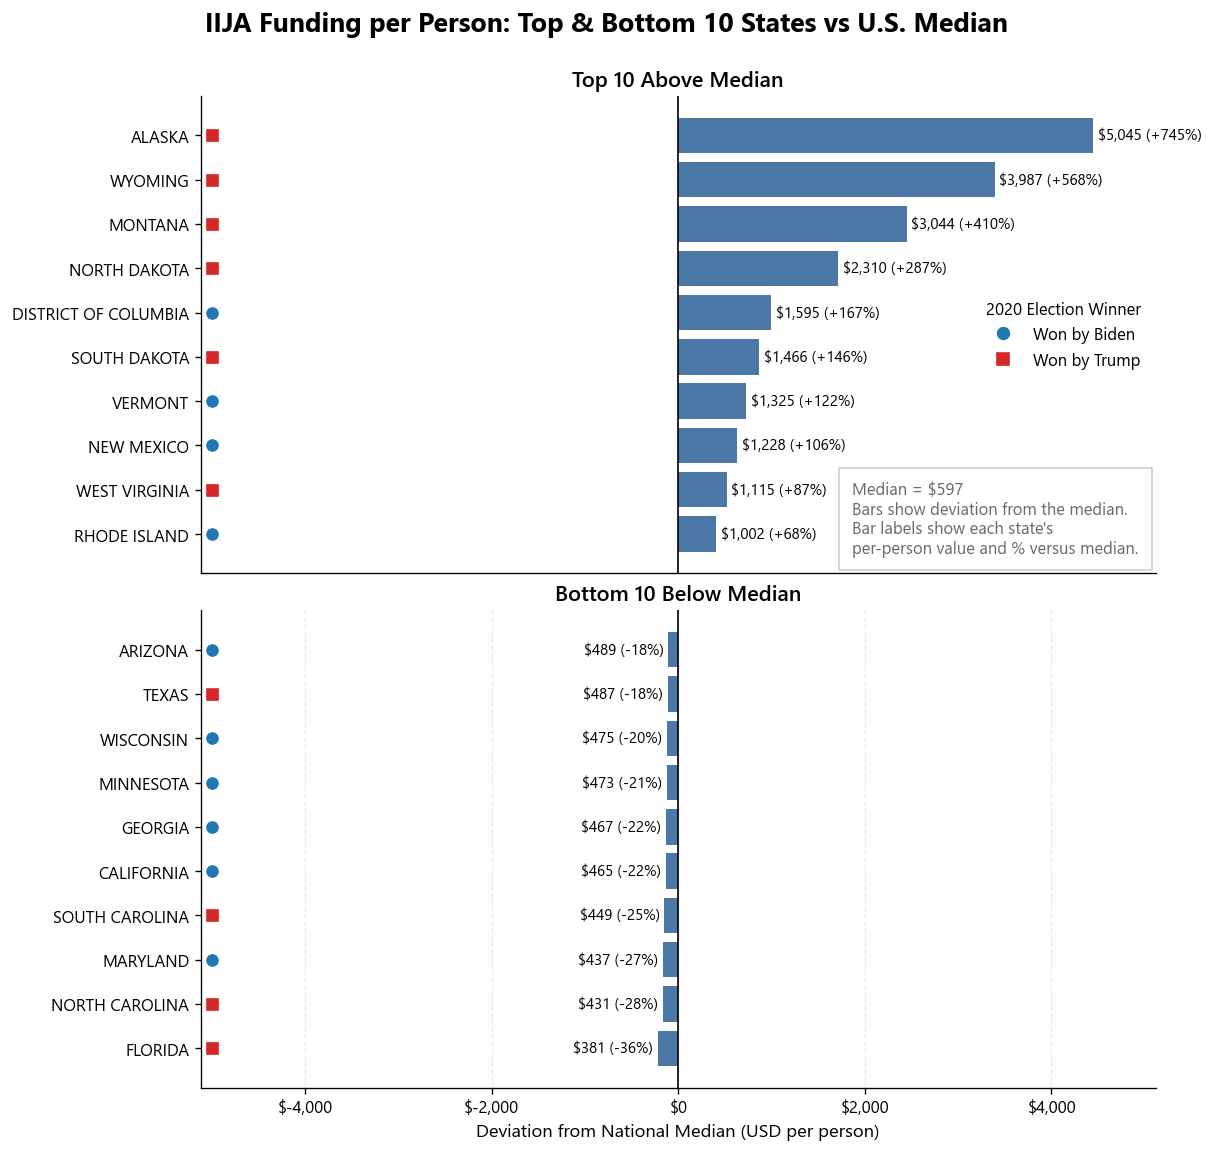

In [ ]:



try:
    df_iija
except NameError:
    df_iija = pd.read_csv(path) 

df = df_iija.copy()
if "is_state_like" in df.columns:
    df = df[df["is_state_like"]].copy()

df["per_capita_usd"] = pd.to_numeric(df["per_capita_usd"], errors="coerce")
df = df.dropna(subset=["per_capita_usd", "entity"])

med = df["per_capita_usd"].median()
df["dev"] = df["per_capita_usd"] - med
df["pct"] = 100 * df["dev"] / med

top = df.nlargest(10, "dev").sort_values("dev").copy()
bot = df.nsmallest(10, "dev").sort_values("dev").copy()

# styling constant
BIDEN_BLUE = "#1f77b4"
TRUMP_RED  = "#d62728"
BAR_COLOR  = "#4C78A8"
WIN_S      = 70  

lim = 1.15 * max(top["dev"].max(), abs(bot["dev"].min()))
fmt = FuncFormatter(lambda x, _: f"${x:,.0f}")

plt.rcParams.update({
    "axes.titlesize": 13, "axes.labelsize": 11,
    "xtick.labelsize": 10, "ytick.labelsize": 10,
    "axes.spines.right": False, "axes.spines.top": False,
    "figure.dpi": 120
})

# plot
fig = plt.figure(figsize=(10, 9), constrained_layout=True)
gs  = fig.add_gridspec(2, 1, height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

def panel(ax, dat, title, left_labels):
    ax.axvline(0, color="black", lw=1)
    ax.set_xlim(-lim, lim)
    ax.set_title(title)
    ax.set_ylabel("")

    bars = ax.barh(dat["entity"], dat["dev"], color=BAR_COLOR)

    # Y centers for each bar
    ycenters = np.array([b.get_y() + b.get_height()/2 for b in bars])

    # mask for winner
    mask_b = dat["biden_win_2020"].fillna(False).astype(bool).to_numpy()
    yb = ycenters[mask_b]
    yr = ycenters[~mask_b]

    # winner markers next to labels 
    if yb.size:
        ax.scatter(np.full(yb.size, 0.012), yb,
                   transform=ax.get_yaxis_transform(),
                   marker='o', s=WIN_S, color=BIDEN_BLUE,
                   edgecolors='white', linewidths=0.8, zorder=3)
    if yr.size:
        ax.scatter(np.full(yr.size, 0.012), yr,
                   transform=ax.get_yaxis_transform(),
                   marker='s', s=WIN_S, color=TRUMP_RED,
                   edgecolors='white', linewidths=0.8, zorder=3)

    # value labels at bar ends
    for b, (_, r) in zip(bars, dat.iterrows()):
        x = b.get_width()
        y = b.get_y() + b.get_height()/2
        txt = f"${r['per_capita_usd']:,.0f} ({r['pct']:+.0f}%)"
        ax.text(x - lim*0.01 if left_labels else x + lim*0.01,
                y, txt, va="center",
                ha="right" if left_labels else "left", fontsize=9)

# top panel 
panel(ax1, top, "Top 10 Above Median", left_labels=False)
ax1.tick_params(axis="x", which="both", labelbottom=False, bottom=False)

# bottom panel 
panel(ax2, bot, "Bottom 10 Below Median", left_labels=True)
ax2.grid(axis="x", ls="--", alpha=.25)
ax2.set_xlabel("Deviation from National Median (USD per person)")
ax2.xaxis.set_major_formatter(fmt)

#title
fig.suptitle("IIJA Funding per Person: Top & Bottom 10 States vs U.S. Median",
             fontsize=16, weight="bold", y=1.05)

# explanation box on the top panel
note = AnchoredText(
    f"Median = ${med:,.0f}\n"
    "Bars show deviation from the median.\n"
    "Bar labels show each state's\n"
    "per-person value and % versus median.",
    loc="lower right", pad=0.4, borderpad=0.6,
    prop={"size": 10, "color": "dimgray"}, frameon=True
)
note.patch.set_boxstyle("round,pad=0.4,rounding_size=0.02")
note.patch.set_facecolor("white"); note.patch.set_edgecolor("#cccccc"); note.patch.set_alpha(0.95)
ax1.add_artist(note)

# legends for winner markers
legend_elems = [
    Line2D([0], [0], marker='o', linestyle='none', color=BIDEN_BLUE, label='Won by Biden', markersize=7),
    Line2D([0], [0], marker='s', linestyle='none', color=TRUMP_RED,  label='Won by Trump', markersize=7),
]
ax1.legend(handles=legend_elems, title="2020 Election Winner", loc="center right", frameon=False)


plt.show()


## Key findings:

* Median ≈ $597/person — that’s the anchor.

* As we see the distribution is right-skewed: a few small states are well over the median (AK $5,045 +745%; WY +568%; MT +410%).

* Bottom side distribution is mild: big states cluster ~–20–30%; bottom is Florida $381 (–36%).

* The plot doesn't have an evidence of a partisan story: both Biden and Trump won states appear in top and bottom tens.

* Takeaway: per-capita IIJA fundings per states varies wildly, probably driven mostly by small-state infrastructure needs, not clear evidence of favoritism.

In [159]:
pio.renderers.default = "plotly_mimetype"
df = pd.read_csv(path)

state_codes = {
    'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AR', 'CALIFORNIA': 'CA',
    'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE', 'FLORIDA': 'FL', 'GEORGIA': 'GA',
    'HAWAII': 'HI', 'IDAHO': 'ID', 'ILLINOIS': 'IL', 'INDIANA': 'IN', 'IOWA': 'IA',
    'KANSAS': 'KS', 'KENTUCKY': 'KY', 'LOUISIANA': 'LA', 'MAINE': 'ME', 'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA', 'MICHIGAN': 'MI', 'MINNESOTA': 'MN', 'MISSISSIPPI': 'MS',
    'MISSOURI': 'MO', 'MONTANA': 'MT', 'NEBRASKA': 'NE', 'NEVADA': 'NV', 'NEW HAMPSHIRE': 'NH',
    'NEW JERSEY': 'NJ', 'NEW MEXICO': 'NM', 'NEW YORK': 'NY', 'NORTH CAROLINA': 'NC',
    'NORTH DAKOTA': 'ND', 'OHIO': 'OH', 'OKLAHOMA': 'OK', 'OREGON': 'OR', 'PENNSYLVANIA': 'PA',
    'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC', 'SOUTH DAKOTA': 'SD', 'TENNESSEE': 'TN',
    'TEXAS': 'TX', 'UTAH': 'UT', 'VERMONT': 'VT', 'VIRGINIA': 'VA', 'WASHINGTON': 'WA',
    'WEST VIRGINIA': 'WV', 'WISCONSIN': 'WI', 'WYOMING': 'WY', 'DISTRICT OF COLUMBIA': 'DC'
}
df['state_code'] = df['entity'].apply(lambda x: state_codes.get(x.upper()))
df_states = df.dropna(subset=['state_code']).copy()
df_states['win_color'] = df_states['biden_win_2020'].map({True: 'blue', False: 'red'})

df_states['winner'] = np.where(df_states['biden_win_2020'],
                               'Joe Biden (2020)', 'Donald Trump (2020)')

national_avg = df_states['total_usd'].sum() / df_states['population_2020'].sum()

#list of tick valueson the colorbar
tick_values = list(np.arange(0, 5001, 1000)) #ticks every $1000
tick_values.append(national_avg)
tick_values = sorted(list(set(tick_values))) 

#text labels for tick values
tick_labels = []
for val in tick_values:
    if abs(val - national_avg) < 1: 
        #bolded label for the average
        tick_labels.append(f"<b>National<br> average:<br>${val:,.0f}</b>")
    else:
        tick_labels.append(f"${val:,.0f}")


fig = go.Figure()

# choropleth map layer
dark_blues = [
    [0.00, '#9fb3c8'],  
    [0.30, '#6b8fb9'],
    [0.60, '#3f6ea8'],
    [0.85, '#1f4f8a'],
    [1.00, '#0b3b75']   
]
fig.add_trace(go.Choropleth(
    locations=df_states['state_code'],
    z=df_states['per_capita_usd'],
    locationmode='USA-states',
    colorscale=dark_blues,
    reversescale=False,
    marker_line_color='white',
    colorbar=dict(
        title='Per Capita<br>Funding (USD)',
        orientation='h',
        x=0.5,
        xanchor='center',
        y=-0.1,
        yanchor='bottom',
        len=0.7, 
        
        tickvals=tick_values,
        ticktext=tick_labels
    )
))

fig.update_traces(
    selector=dict(type='choropleth'),
    customdata=np.column_stack([
        df_states['entity'],
        df_states['winner'],
        df_states['per_capita_usd']
    ]),
    hovertemplate=(
        "<b>%{customdata[0]}</b><br>"
        "Winner: %{customdata[1]}<br>"
        "Per capita: $%{customdata[2]:,.0f}"
        "<extra></extra>"
    )
)
#text layer on top of the map
fig.add_scattergeo(
    locationmode = 'USA-states',
    locations = df_states['state_code'],
    text = df_states['state_code'],
    mode = 'text',
    hoverinfo='none',
    textfont = {
        'color': df_states['win_color'],
        'size': 12,
        'family': 'Arial, sans-serif'
    }
)

#layout for a clean, minimal look
fig.update_layout(
    title=dict(
        text="Variation in IIJA Funding per Person, by State"
         "<br><sup>USD per resident; darker color is equal to more fundings per capita than national average</sup>",
        x=0.02, xanchor="left"
    ),
    geo_scope='usa',
    template='plotly_white',
    height=850, width=1400,
    geo=dict(showframe=False, showcoastlines=False, projection_type='albers usa'),
   
    annotations=[
        go.layout.Annotation(
            showarrow=False,
            text=
                 "States won by D. Trump are in red<br>"
                 "States won by J. Biden are in blue<br>"
                 f"<b>Key Observations:</b><br>" +
                 f"• The national average allocation is<br> <b>${national_avg:,.2f}</b> per person.<br>" +
                 "• Funding is not equitable by population;<br> less populous states like<br>" +
                 "  AK, WY, and MT receive<br> the most per capita.<br>" +
                 "• No clear political bias is apparent,<br> with high funding<br>" +
                 "  in both Republican (AK, WY)<br> and Democratic (VT, RI) states.",
            align='right', x=1, xanchor='right', y=0.03, yanchor='bottom',
            xref="paper", yref="paper",
            bgcolor="rgba(255, 255, 255, 0.7)", bordercolor='rgba(0,0,0,0)',
            font=dict(family="Arial, sans-serif", size=14, color="black")
        ),
        go.layout.Annotation(
            showarrow=False,
            text=(
                 f"You can hover over state to see</b><br>"
                 f"the winner candidate,.<br>"
                 "and the state's average per capita received funds<br>"
                 
            ),
            align='left', x=0.75, xanchor='right',
            y=0.97, yanchor='top',           
            xref="paper", yref="paper",
            bgcolor="rgba(255, 255, 255, 0.7)", bordercolor='rgba(0,0,0,0)',
            font=dict(family="Arial, sans-serif", size=14, color="black")
        )
    ]

    
)

fig.show(config={'scrollZoom': False})
fig.write_image("map.png", scale=2)          # static fallback
from IPython.display import Image, display
display(Image("map.png"))                    # embeds the PNG in the notebook
# Optional: also save an interactive copy to link from README
fig.write_html("map.html", include_plotlyjs="cdn")

ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


### Where is the money going?

This map gives a view of the funding. Here’s how to read it:

* **The color** of the state shows how much funding it got per person. The "Per Capita Funding" bar on the bottom shows different colors as amount increases.
* **The text** on each state is its two-letter code.
* **The color of the text** shows the 2020 election result: **blue** for states Biden won, and **red** for states Trump won.

We can see that many of the states with the highest per-person funding are less-populated states in the West and Northeast, and each of these states won by D. Trump.

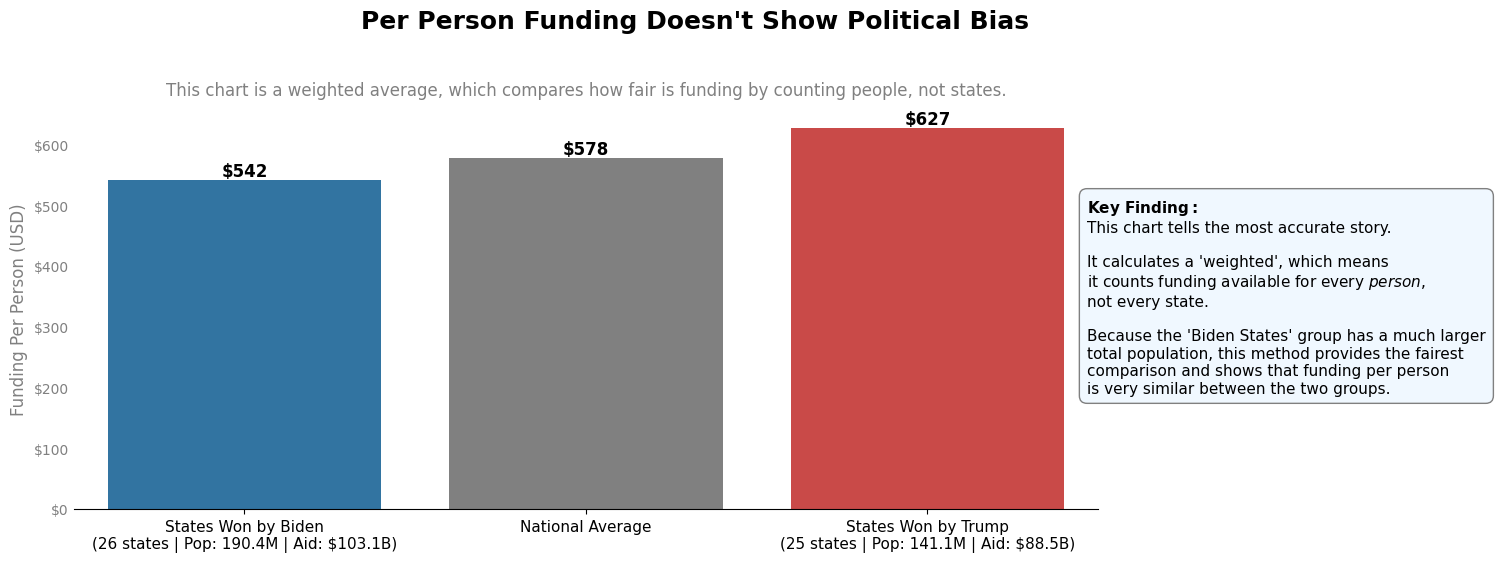

In [25]:
biden_states = df_states[df_states['biden_win_2020'] == True]
trump_states = df_states[df_states['biden_win_2020'] == False]
biden_total_pop = biden_states['population_2020'].sum()
biden_total_funding = biden_states['total_usd'].sum()
biden_weighted_avg = biden_total_funding / biden_total_pop
trump_total_pop = trump_states['population_2020'].sum()
trump_total_funding = trump_states['total_usd'].sum()
trump_weighted_avg = trump_total_funding / trump_total_pop
num_biden_states = len(biden_states)
num_trump_states = len(trump_states)

biden_label = f"States Won by Biden\n({num_biden_states} states | Pop: {biden_total_pop/1e6:.1f}M | Aid: ${biden_total_funding/1e9:.1f}B)"
trump_label = f"States Won by Trump\n({num_trump_states} states | Pop: {trump_total_pop/1e6:.1f}M | Aid: ${trump_total_funding/1e9:.1f}B)"
national_label = "National Average"
national_avg_per_capita = df_states['total_usd'].sum() / df_states['population_2020'].sum()


plot_data = {
    'Group': [biden_label, national_label, trump_label],
    'Value': [biden_weighted_avg, national_avg_per_capita, trump_weighted_avg]
}
plot_df = pd.DataFrame(plot_data)

# creating chart
fig, ax = plt.subplots(figsize=(14, 6)) 
palette_colors = {biden_label: '#1F77B4', national_label: 'grey', trump_label: '#DE3533'}
sns.barplot(x='Group', y='Value', data=plot_df, hue='Group', palette=palette_colors, legend=False, ax=ax, edgecolor="none")

for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"${bar.get_height():,.0f}",
            ha="center", va="bottom", fontsize=12, fontweight='bold', color='black')

formatter = FuncFormatter(lambda y, _: f'${int(y):,}')
ax.yaxis.set_major_formatter(formatter)
fig.suptitle("Per Person Funding Doesn't Show Political Bias", fontsize=18, fontweight='bold', ha='center')
ax.set_title("This chart is a weighted average, which compares how fair is funding by counting people, not states.", fontsize=12, color='gray', pad=10)
ax.set_ylabel("Funding Per Person (USD)", fontsize=12, color='gray')
ax.set_xlabel("")
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='black', labelsize=11)
sns.despine(left=True)
ax.tick_params(axis='y', length=0)

#explanatory text box
explanation_text = (
    r"$\bf{Key\ Finding:}$" + "\n"
    r"This chart tells the most accurate story." + "\n\n"
    r"It calculates a 'weighted', which means" + "\n"
    r"it counts funding available for every " + r"$\it{person}$" + ",\n"
    r"not every state" + "." + "\n\n"
    "Because the 'Biden States' group has a much larger\n"
    "total population, this method provides the fairest\n"
    "comparison and shows that funding per person\n"
    "is very similar between the two groups."
)
fig.text(0.78, 0.5, explanation_text, ha='left', va='center', fontsize=11,
         bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', ec='grey', lw=1))

plt.subplots_adjust(right=0.75)
plt.tight_layout(rect=[0, 0.05, 0.8, 0.95]) 
plt.show()

### How the "Weighted Average" is Calculated

This chart gives an answer to our main question: *"Is the funding equitable based on population, or is there a political bias?"*

The calculation is a **weighted average**, which is the fairest way to compare the two groups of states won by each candidate. Instead of every state getting an equal vote, every *person* gets an equal vote. This means states with larger populations have a proportionally larger impact on the final average.



#### The Formula

The formula is the total sum of money given to a group of states, divided by the total number of people living in that group of states.

**Weighted Average** = (Total Funding for All States in the Group) / (Total Population of All States in the Group)



#### A Quick Example

Let's look at a simplified "Trump won states" group with just two states:

* **Wyoming:** Population 0.6M, Funding \$2.3B (\~**\$3,987** per person)
* **Texas:** Population 29M, Funding \$13B (\~**\$448** per person)

A *simple average* would be `($3987 + $448) / 2 = $2,217`, which is very high.

But the **weighted average** correctly accounts for the huge population of Texas:

* **Total Funding:** \$2.3B + \$13B = \$15.3B
* **Total Population:** 0.6M + 29M = 29.6M
* **Result:** `\$15.3B / 29.6M =` **\$517** per person.

As we can see, the large population of Texas pulls the average much closer to its own per-capita number. This is a much more accurate reflection of the average person in this group.



#### The Code

In our Python script, this is calculated in three steps:

```python
# 1. Sum the total funding for the group
trump_total_funding = trump_states['total_usd'].sum()

# 2. Sum the total population for the group
trump_total_pop = trump_states['population_2020'].sum()

# 3. Divide the two sums
trump_weighted_avg = trump_total_funding / trump_total_pop

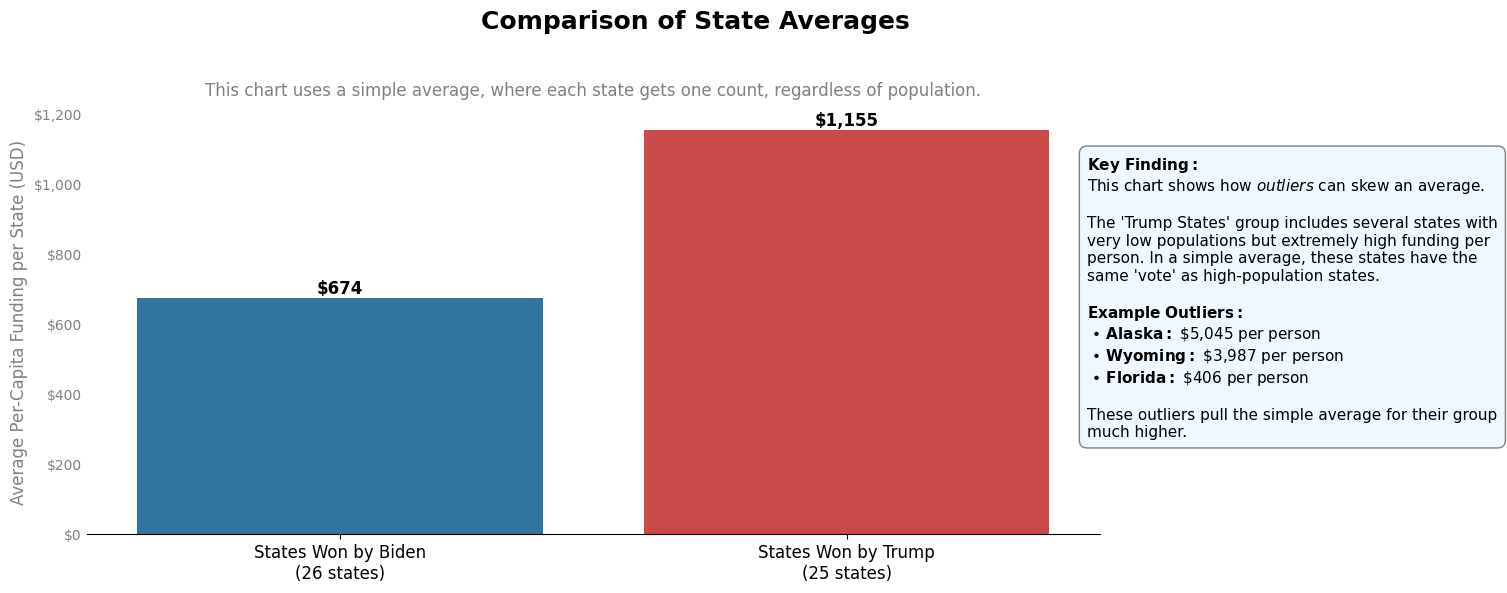

In [ ]:
biden_states = df_states[df_states['biden_win_2020'] == True]
trump_states = df_states[df_states['biden_win_2020'] == False]
biden_simple_avg = biden_states['per_capita_usd'].mean()
trump_simple_avg = trump_states['per_capita_usd'].mean()

#data for plotting
plot_data = {
    'Group': [f"States Won by Biden\n({len(biden_states)} states)", f"States Won by Trump\n({len(trump_states)} states)"],
    'Value': [biden_simple_avg, trump_simple_avg]
}
plot_df = pd.DataFrame(plot_data)

#creating chart
fig, ax = plt.subplots(figsize=(14, 6)) 
palette_colors = {plot_df.iloc[0,0]: '#1F77B4', plot_df.iloc[1,0]: '#DE3533'}
sns.barplot(x='Group', y='Value', data=plot_df, hue='Group', palette=palette_colors, legend=False, ax=ax, edgecolor="none")

for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"${bar.get_height():,.0f}",
            ha="center", va="bottom", fontsize=12, fontweight='bold', color='black')

formatter = FuncFormatter(lambda y, _: f'${int(y):,}')
ax.yaxis.set_major_formatter(formatter)
fig.suptitle("Comparison of State Averages", fontsize=18, fontweight='bold', ha='center')
ax.set_title("This chart uses a simple average, where each state gets one count, regardless of population.", fontsize=12, color='gray', pad=10)
ax.set_ylabel("Average Per-Capita Funding per State (USD)", fontsize=12, color='gray')
ax.set_xlabel("")
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='black', labelsize=12)
sns.despine(left=True)
ax.tick_params(axis='y', length=0)

#the explanatory text box
explanation_text = (
    r"$\bf{Key\ Finding:}$" + "\n"
    r"This chart shows how $\it{outliers}$ can skew an average." + "\n\n"
    "The 'Trump States' group includes several states with\n"
    "very low populations but extremely high funding per\n"
    "person. In a simple average, these states have the\n"
    "same 'vote' as high-population states.\n\n"
    r"$\bf{Example\ Outliers:}$" + "\n"
    r" • " + r"$\bf{Alaska:}$" + r" \$5,045 per person" + "\n"
    r" • " + r"$\bf{Wyoming:}$" + r" \$3,987 per person" + "\n"
    r" • " + r"$\bf{Florida:}$" + r" \$406 per person" + "\n\n"
    "These outliers pull the simple average for their group\n"
    "much higher."
)
# position the text on the right side of the figure
fig.text(0.78, 0.5, explanation_text, ha='left', va='center', fontsize=11,
         bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', ec='grey', lw=1))

# adjust the plot to make space for the text
plt.subplots_adjust(right=0.75)
plt.tight_layout(rect=[0, 0, 0.8, 0.95]) 
plt.show()


### How the "Simple Average" for Each Side is Calculated

This chart answers a different question: "If you pick a state at random from each group, what's its *typical* per-capita funding?"

The calculation is a **simple average**, where every state gets one count, regardless of its population.



#### The Formula

The formula is just like a simple average we'd do for any list of numbers:

**Simple Average** = (Sum of the Per-Capita Funding for Every State in the Group) / (Total Number of States in the Group)


#### A Quick Example (Why the Trump States' Average is So High)

The simple average can be heavily skewed by **outliers**. Let's look at just three states won by Trump:

* **Alaska:** \$5,045 per person
* **Wyoming:** \$3,987 per person
* **Florida:** \$406 per person

The simple average for just these three is: `($5,045 + $3,987 + $406) / 3 = $3,146`.

As you can see, the two low-population states with huge funding numbers pull the average way up. Florida's much larger population doesn't give it any extra weight in this calculation.



#### The Code

In Python script, this formula is calculated in this line:

```python
# simple average for the 'per_capita_usd' column
trump_simple_avg = trump_states['per_capita_usd'].mean()

## Conclusions

Our analysis of the Infrastructure Investment and Jobs Act (IIJA) funding set out to answer two main questions. Based on the data, we can draw two clear conclusions:



### 1. The funding is **not equitable** based on population.

Our analysis, particularly the choropleth map, showed a clear and significant pattern: **less populous states receive substantially more funding per capita than more populous states.** This suggests that the IIJA funding formula is based on factors other than just population, likely guaranteeing a baseline of funding for each state to address critical infrastructure needs regardless of its size.



### 2. The allocation **does not show evidence of political bias**.

We investigated whether the funding favored states based on the 2020 presidential election results and found no evidence to support this idea.

* **The Fairest Measure:** The most accurate way to compare the two groups is by using a **weighted average**, which counts the funding available per person.
* **The Key Finding:** On a per-person basis, states won by Trump actually received slightly more funding (**\$627 per person**) than states won by Biden (**\$542 per person**).

This result directly contradicts the idea that the allocation was politically motivated to favor the current administration. The primary driver for high per-capita funding appears to be low population, not politics.


### 3. Further analysis
There is a chance that this research's findings could be misleading if fundings were distributed without favoritism. To get a better answer, the research has to be done accounting actual states infrastracture needs (e.g. states highway miles to be repaired, broadband internet coverage, public transit & passenger/freight rail needs and other infrastrucure parts covered by IJAA )